In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.stats import pearsonr
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import spacy
from collections import Counter
from scipy.stats import shapiro, normaltest
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
import subprocess
import json
import numpy as np
from collections import defaultdict
import os
from scipy.stats import spearmanr

In [ ]:
file_path = "questions_without_material.csv"
df = pd.read_csv(file_path)

In [63]:
len(df)

2600

In [64]:
df.head()

,id,Пакет,№,Вопрос,Ответ,Зачет,Комментарий,Источник,Авторы,Доля взятия,Процент взятия,Год
0,1,Умлаут Special: Сова в пабе 2019,1.0000,"В передаче Андрея Понкратова рассказывается, ч...",Носами,Нос,Приветствие касанием носа – традиция жителей с...,https://youtu.be/BW63sNTOD8Q?t=1513,"Андрей Кунилов (Мюнхен), Марина Парр (Мюнхен)",120/132,91.0000,2018_2019
1,2,Умлаут Special: Сова в пабе 2019,2.0000,Одна из сцен “Московского центра драматургии и...,выключать мобильные телефоны,"выключать сотовые телефоны, синонимичные ответы",перед началом спектакля голос по громкоговорит...,https://typical-moscow.ru/mama-cdr-istoriya-od...,"Андрей Кунилов (Мюнхен), Марина Парр (Мюнхен)",107/132,81.0000,2018_2019
2,3,Умлаут Special: Сова в пабе 2019,3.0000,"Статья ""National Geographic"" ""ПРОПУСК тела про...",пластика,точный ответ,"В фотопроекте Григория Шелухина ""Крохотная сме...",http://www.nat-geo.ru/planet/1190948-plastika-...,Борис Рабинович (Тель-Авив),93/132,70.0000,2018_2019
3,4,Умлаут Special: Сова в пабе 2019,4.0000,"Фантастическое животное демимаска, придуманное...",Нострадамус,Точный ответ,Особо неуязвимым демимаску делает способность ...,https://ru.wikipedia.org/wiki/Нострадамус,Борис Рабинович (Тель-Авив),40/132,30.0000,2018_2019
4,5,Умлаут Special: Сова в пабе 2019,5.0000,В постановке мюнхенского детского театра один ...,[вместо] мозгов,"[вместо] ума. Зачет по слову “мозг”, “ум”, “ра...",Речь о постановке Волшебника страны Оз. В сцен...,NaN,Максим Мозуль (Мюнхен),44/132,33.0000,2018_2019


# 1. Длина вопроса и успешность ответа

In [65]:
df["Длина (слова)"] = df["Вопрос"].apply(lambda x: len(str(x).split()))
df["Длина (символы)"] = df["Вопрос"].apply(lambda x: len(str(x)))
df["Процент взятия"] = pd.to_numeric(df["Процент взятия"], errors="coerce")

In [7]:
import pandas as pd

length_stats = {
    'Средняя длина': df['Длина (слова)'].mean(),
    'Медиана': df['Длина (слова)'].median(),
    'Стандартное отклонение': df['Длина (слова)'].std(),
    'Минимальная длина': df['Длина (слова)'].min(),
    'Максимальная длина': df['Длина (слова)'].max(),
    '25-й перцентиль': df['Длина (слова)'].quantile(0.25),
    '75-й перцентиль': df['Длина (слова)'].quantile(0.75)
}

stats_df = pd.DataFrame.from_dict(length_stats, orient='index', columns=['Значение'])
stats_df['Значение'] = stats_df['Значение'].round(2)

print("Статистика длины вопросов (в словах):")
print(stats_df)

Статистика длины вопросов (в словах):
                        Значение
Средняя длина              29.13
Медиана                    29.00
Стандартное отклонение      8.08
Минимальная длина           7.00
Максимальная длина         65.00
25-й перцентиль            23.00
75-й перцентиль            34.00


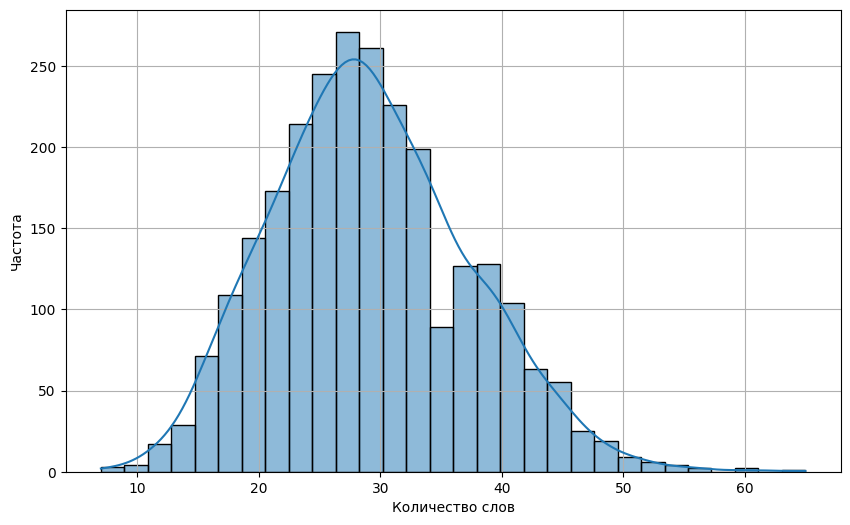

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Длина (слова)'], bins=30, kde=True)
#plt.title('Распределение длины вопросов (в словах)')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [10]:
q25 = df['Длина (слова)'].quantile(0.25)
q75 = df['Длина (слова)'].quantile(0.75)

long_threshold = df['Длина (слова)'].quantile(0.90)
print(f"\nПорог для длинных вопросов: >{int(long_threshold)} слов (90-й перцентиль)")
long_questions_ratio = len(df[df['Длина (слова)'] > long_threshold]) / len(df)
print(f"Доля длинных вопросов: {long_questions_ratio:.1%}")

q10 = df['Длина (слова)'].quantile(0.10)
q90 = df['Длина (слова)'].quantile(0.90)
print(f"\n80% вопросов имеют длину от {int(q10)} до {int(q90)} слов")
print(f"50% вопросов имеют длину от {int(q25)} до {int(q75)} слов")


Порог для длинных вопросов: >40 слов (90-й перцентиль)
Доля длинных вопросов: 9.0%

80% вопросов имеют длину от 19 до 40 слов
50% вопросов имеют длину от 23 до 34 слов


In [13]:
# Тест Шапиро-Уилка (для выборок <5000)
stat, p = shapiro(df['Длина (слова)'])
print(f"Shapiro-Wilk test: p-value = {p:.4f}")

# Тест D'Agostino K² (для любых размеров выборки)
stat, p = normaltest(df['Длина (слова)'])
print(f"D'Agostino K² test: p-value = {p:.4f}")

alpha = 0.05
if p > alpha:
    print("Распределение нормальное (не отвергаем H0)")
else:
    print("Распределение не нормальное (отвергаем H0)")

Shapiro-Wilk test: p-value = 0.0000
D'Agostino K² test: p-value = 0.0000
Распределение не нормальное (отвергаем H0)


In [14]:
skewness = df['Длина (слова)'].skew()
print(f"Коэффициент асимметрии: {skewness:.2f}")

Коэффициент асимметрии: 0.34


In [15]:
kurtosis = df["Длина (слова)"].kurtosis()
print(f"Эксцесс: {kurtosis:.2f}")

Эксцесс: 0.08


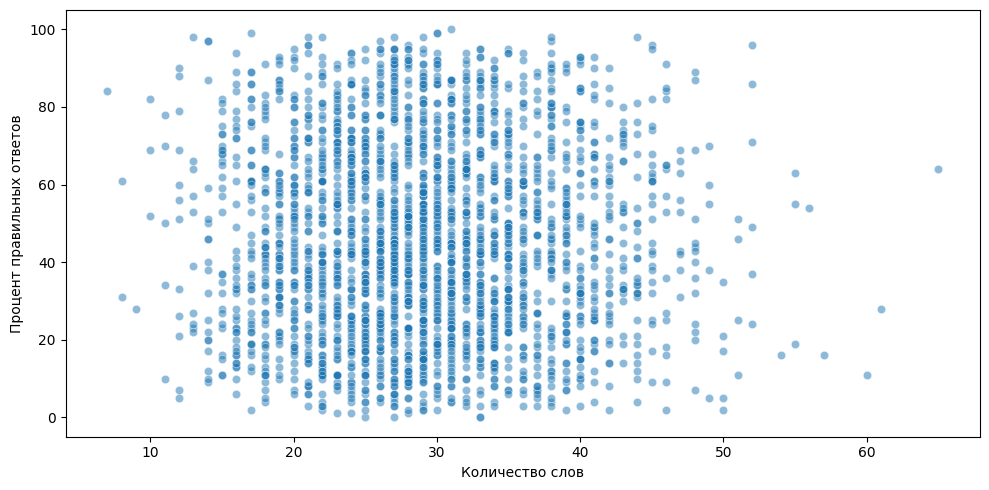

In [16]:
plt.figure(figsize=(10, 5))

sns.scatterplot(x=df["Длина (слова)"], y=df["Процент взятия"], alpha=0.5)

# Добавляем подписи
plt.xlabel("Количество слов")
plt.ylabel("Процент правильных ответов")
#plt.title("Зависимость успешности ответа от длины (в словах)")

plt.tight_layout()
plt.show()

In [17]:
# Корреляция по словам:
correlation, p_value = pearsonr(df["Длина (слова)"], df["Процент взятия"])

print(f"Корреляция между длиной вопроса (слов) и процентом взятия: {correlation:.3f}")
print(f"p-value: {p_value:.3f}")

Корреляция между длиной вопроса (слов) и процентом взятия: -0.003
p-value: 0.861


In [ ]:
correlation, p_value = spearmanr(df["Длина (слова)"], df["Процент взятия"])

print(f"Корреляция между длиной вопроса (слов) и процентом взятия: {correlation:.3f}")
print(f"p-value: {p_value:.3f}")

Корреляция между длиной вопроса (слов) и процентом взятия: 0.003
p-value: 0.870


Мы получили очень слабую отрицательную корреляцию, которая говорит о том, что между длиной вопроса и процентом правильных ответов нет значимой зависимости.

In [19]:
bins = [0, q25, q75, df["Длина (слова)"].max()]
labels = ["Короткие", "Средние", "Длинные"]

<Axes: xlabel='Группа', ylabel='Процент взятия'>

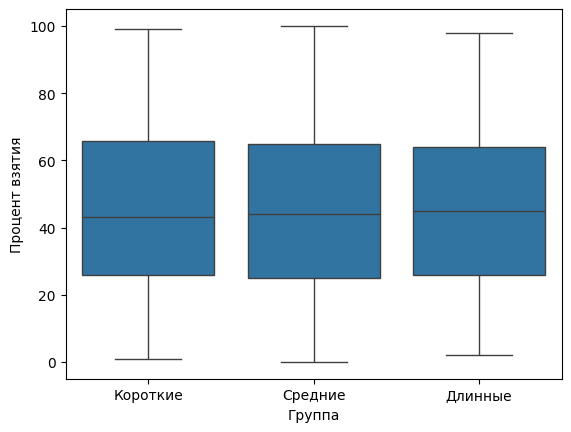

In [20]:
df["Группа"] = pd.cut(df["Длина (слова)"], bins=bins, labels=labels)
sns.boxplot(x="Группа", y="Процент взятия", data=df)

In [22]:
from scipy.stats import kruskal

group_short = df[df["Группа"] == "Короткие"]["Процент взятия"]
group_medium = df[df["Группа"] == "Средние"]["Процент взятия"]
group_long = df[df["Группа"] == "Длинные"]["Процент взятия"]

# Проводим тест
stat, p_value = kruskal(group_short, group_medium, group_long)
print(f"Результат теста Крускала-Уоллиса: p-value = {p_value:.4f}")

# Интерпретация
if p_value < 0.05:
    print("Есть статистически значимые различия между группами.")
else:
    print("Различия между группами не значимы.")

Результат теста Крускала-Уоллиса: p-value = 0.9849
Различия между группами не значимы.



Анализ длины вопросов после фильтрации:
Количество вопросов после фильтрации: 2183
Средняя длина: 28.9 слов
Медиана: 28.0 слов

Тест Шапиро-Уилка на нормальность: p-value = 0.0000

Корреляция Спирмена после фильтрации:
Коэффициент: 0.000, p-value: 0.9924


/var/folders/xf/3726vqvn6dq9rsmt7g0rltqr0000gn/T/ipykernel_51453/4090439042.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Группа'] = pd.cut(df_filtered['Длина (слова)'],


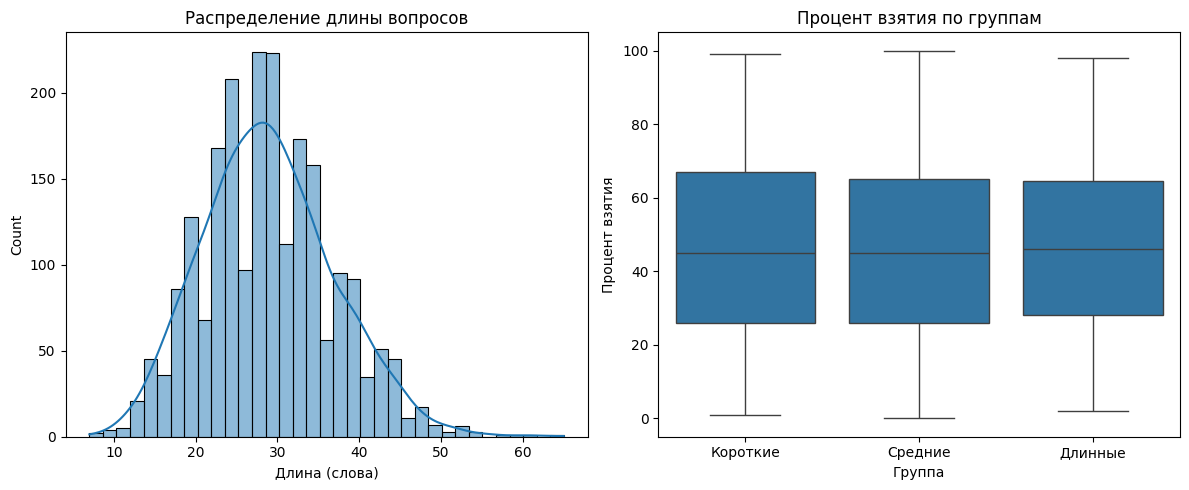


Результаты теста Крускала-Уоллиса для групп:
p-value: 0.8728


In [23]:
#Фильтрация данных
df_filtered = df[~df['Год'].isin(['2024_2025'])]

print("\nАнализ длины вопросов после фильтрации:")
print(f"Количество вопросов после фильтрации: {len(df_filtered)}")
print(f"Средняя длина: {df_filtered['Длина (слова)'].mean():.1f} слов")
print(f"Медиана: {df_filtered['Длина (слова)'].median():.1f} слов")

stat, p = shapiro(df_filtered['Длина (слова)'])
print(f"\nТест Шапиро-Уилка на нормальность: p-value = {p:.4f}")

corr, p_val = spearmanr(df_filtered['Длина (слова)'], df_filtered['Процент взятия'])
print(f"\nКорреляция Спирмена после фильтрации:")
print(f"Коэффициент: {corr:.3f}, p-value: {p_val:.4f}")

q25 = df_filtered['Длина (слова)'].quantile(0.25)
q75 = df_filtered['Длина (слова)'].quantile(0.75)
df_filtered['Группа'] = pd.cut(df_filtered['Длина (слова)'], 
                              bins=[0, q25, q75, df_filtered['Длина (слова)'].max()],
                              labels=["Короткие", "Средние", "Длинные"])


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_filtered['Длина (слова)'], kde=True)
plt.title('Распределение длины вопросов')

plt.subplot(1, 2, 2)
sns.boxplot(x='Группа', y='Процент взятия', data=df_filtered)
plt.title('Процент взятия по группам')

plt.tight_layout()
plt.show()

from scipy.stats import kruskal
short = df_filtered[df_filtered['Группа'] == 'Короткие']['Процент взятия']
medium = df_filtered[df_filtered['Группа'] == 'Средние']['Процент взятия']
long = df_filtered[df_filtered['Группа'] == 'Длинные']['Процент взятия']

print("\nРезультаты теста Крускала-Уоллиса для групп:")
stat, p = kruskal(short, medium, long)
print(f"p-value: {p:.4f}")

# 2. Отличия по годам.

In [24]:
yearly_stats = df.groupby('Год').agg(
    Средняя_длина=('Длина (слова)', 'mean'),
    Медианная_длина=('Длина (слова)', 'median'),
    Средний_процент=('Процент взятия', 'mean'),
    Количество=('Вопрос', 'count')
).round(2)

yearly_stats['Процент_от_общего'] = (yearly_stats['Количество'] / yearly_stats['Количество'].sum() * 100).round(2)


In [25]:
yearly_stats

,Средняя_длина,Медианная_длина,Средний_процент,Количество,Процент_от_общего
Год,,,,,
2018_2019,29.17,28.0,50.86,29,1.12
2019_2020,27.78,27.0,51.25,474,18.23
2020_2021,27.31,27.0,49.02,427,16.42
2021_2022,27.77,27.5,42.11,422,16.23
2022_2023,30.02,30.0,44.67,416,16.00
2023_2024,31.74,31.0,45.28,415,15.96
2024_2025,30.42,30.0,41.32,417,16.04


In [26]:
years = df['Год'].unique()
groups = [df[df['Год'] == year]['Процент взятия'] for year in years]
stat, p_value = kruskal(*groups)

print(f"Тест Крускала-Уоллиса на различия между годами: p = {p_value:.4f}")

Тест Крускала-Уоллиса на различия между годами: p = 0.0000


In [28]:
stat_len, p_len = kruskal(*[df[df['Год']==year]['Длина (слова)'] for year in df['Год'].unique()])

stat_succ, p_succ = kruskal(*[df[df['Год']==year]['Процент взятия'] for year in df['Год'].unique()])

print(f"Длина вопросов: H = {stat_len:.1f}, p = {p_len:.4f}")
print(f"Успешность ответов: H = {stat_succ:.1f}, p = {p_succ:.4f}")

Длина вопросов: H = 100.6, p = 0.0000
Успешность ответов: H = 56.3, p = 0.0000


In [29]:
from scikit_posthocs import posthoc_dunn


posthoc_length = posthoc_dunn([df[df['Год']==year]['Длина (слова)'] for year in sorted(df['Год'].unique())], 
                             p_adjust='bonferroni')


posthoc_success = posthoc_dunn([df[df['Год']==year]['Процент взятия'] for year in sorted(df['Год'].unique())],
                              p_adjust='bonferroni')

In [30]:
from scipy.stats import spearmanr

yearly_stats = df.groupby('Год')[['Длина (слова)', 'Процент взятия']].mean()
corr, p = spearmanr(yearly_stats['Длина (слова)'], yearly_stats['Процент взятия'])

print(f"Ранговая корреляция: ρ = {corr:.2f}, p = {p:.4f}")

Ранговая корреляция: ρ = -0.32, p = 0.4821


In [33]:
years = sorted(df['Год'].unique())
data = [df[df['Год'] == year]['Процент взятия'].values for year in years]


posthoc_results = posthoc_dunn(
    data, 
    p_adjust='bonferroni',  # Исправление на множественные сравнения
    sort=True
)


print("\nРезультаты попарных сравнений (тест Данна с поправкой Бонферрони):")
pd.options.display.float_format = '{:.4f}'.format
print(posthoc_results.set_axis([f"{y}" for y in years], axis=0)
         .set_axis([f"{y}" for y in years], axis=1))


print("\nСтатистически значимые различия (p < 0.05):")
significant_pairs = []
for i in range(len(years)):
    for j in range(i+1, len(years)):
        if posthoc_results.iloc[i,j] < 0.05:
            significant_pairs.append(
                f"{years[i]} vs {years[j]}: p = {posthoc_results.iloc[i,j]:.4f}"
            )

if significant_pairs:
    print(*significant_pairs, sep="\n")
else:
    print("Нет значимых различий между годами")


Результаты попарных сравнений (тест Данна с поправкой Бонферрони):
           2018_2019  2019_2020  2020_2021  2021_2022  2022_2023  2023_2024  \
2018_2019     1.0000     1.0000     1.0000     1.0000     1.0000     1.0000   
2019_2020     1.0000     1.0000     1.0000     0.0000     0.0027     0.0068   
2020_2021     1.0000     1.0000     1.0000     0.0004     0.2250     0.4191   
2021_2022     1.0000     0.0000     0.0004     1.0000     1.0000     1.0000   
2022_2023     1.0000     0.0027     0.2250     1.0000     1.0000     1.0000   
2023_2024     1.0000     0.0068     0.4191     1.0000     1.0000     1.0000   
2024_2025     1.0000     0.0000     0.0001     1.0000     0.8054     0.4604   

           2024_2025  
2018_2019     1.0000  
2019_2020     0.0000  
2020_2021     0.0001  
2021_2022     1.0000  
2022_2023     0.8054  
2023_2024     0.4604  
2024_2025     1.0000  

Статистически значимые различия (p < 0.05):
2019_2020 vs 2021_2022: p = 0.0000
2019_2020 vs 2022_2023: p = 0.0027


In [34]:
from itertools import combinations
from scipy.stats import mannwhitneyu

for year1, year2 in combinations(years, 2):
    _, p = mannwhitneyu(
        df[df['Год'] == year1]['Процент взятия'],
        df[df['Год'] == year2]['Процент взятия']
    )
    print(f"{year1} vs {year2}: p = {p:.4f} (скорректированное = {p*len(list(combinations(years, 2))):.4f})")

2018_2019 vs 2019_2020: p = 0.9292 (скорректированное = 19.5133)
2018_2019 vs 2020_2021: p = 0.7792 (скорректированное = 16.3635)
2018_2019 vs 2021_2022: p = 0.1300 (скорректированное = 2.7290)
2018_2019 vs 2022_2023: p = 0.2753 (скорректированное = 5.7803)
2018_2019 vs 2023_2024: p = 0.3044 (скорректированное = 6.3932)
2018_2019 vs 2024_2025: p = 0.0860 (скорректированное = 1.8070)
2019_2020 vs 2020_2021: p = 0.1815 (скорректированное = 3.8118)
2019_2020 vs 2021_2022: p = 0.0000 (скорректированное = 0.0000)
2019_2020 vs 2022_2023: p = 0.0001 (скорректированное = 0.0022)
2019_2020 vs 2023_2024: p = 0.0004 (скорректированное = 0.0078)
2019_2020 vs 2024_2025: p = 0.0000 (скорректированное = 0.0000)
2020_2021 vs 2021_2022: p = 0.0000 (скорректированное = 0.0004)
2020_2021 vs 2022_2023: p = 0.0086 (скорректированное = 0.1816)
2020_2021 vs 2023_2024: p = 0.0206 (скорректированное = 0.4321)
2020_2021 vs 2024_2025: p = 0.0000 (скорректированное = 0.0001)
2021_2022 vs 2022_2023: p = 0.0765 (ск

In [ ]:
def print_significant_pairs(posthoc_matrix, years):
    print("\nСтатистически значимые пары (p < 0.05):")
    years = sorted(years)
    significant_found = False
    
    for i in range(len(years)):
        for j in range(i+1, len(years)):
            p = posthoc_matrix.iloc[i,j]
            if p < 0.05:
                significant_found = True
                print(f"{years[i]} vs {years[j]}: p = {p:.4f}{'*' * (p < 0.01)}")
    
    if not significant_found:
        print("Нет значимых различий между группами")

years = sorted(df['Год'].unique())
print("=== Длина вопросов ===")
print_significant_pairs(posthoc_length, years)

print("\n=== Успешность ответов ===")
print_significant_pairs(posthoc_success, years)

=== Длина вопросов ===

Статистически значимые пары (p < 0.05):
2019_2020 vs 2022_2023: p = 0.0018*
2019_2020 vs 2023_2024: p = 0.0000*
2019_2020 vs 2024_2025: p = 0.0001*
2020_2021 vs 2022_2023: p = 0.0001*
2020_2021 vs 2023_2024: p = 0.0000*
2020_2021 vs 2024_2025: p = 0.0000*
2021_2022 vs 2022_2023: p = 0.0012*
2021_2022 vs 2023_2024: p = 0.0000*
2021_2022 vs 2024_2025: p = 0.0001*
2022_2023 vs 2023_2024: p = 0.0466

=== Успешность ответов ===

Статистически значимые пары (p < 0.05):
2019_2020 vs 2021_2022: p = 0.0000*
2019_2020 vs 2022_2023: p = 0.0027*
2019_2020 vs 2023_2024: p = 0.0068*
2019_2020 vs 2024_2025: p = 0.0000*
2020_2021 vs 2021_2022: p = 0.0004*
2020_2021 vs 2024_2025: p = 0.0001*


/var/folders/xf/3726vqvn6dq9rsmt7g0rltqr0000gn/T/ipykernel_51453/544753839.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f"{years[i]} vs {years[j]}: p = {p:.4f}{'*' * (p < 0.01)}")


In [36]:
import pandas as pd

results = pd.DataFrame({
    'Сравнение': [
        '2019-2020 vs 2021-2022',
        '2019-2020 vs 2022-2023',
        '2019-2020 vs 2023-2024',
        '2019-2020 vs 2024-2025',
        '2020-2021 vs 2021-2022',
        '2020-2021 vs 2024-2025'
    ],
    'p-value': ['< 0.0001', '0.0027', '0.0068', '< 0.0001', '0.0004', '0.0001'],
    'Значимость': ['****', '**', '**', '****', '***', '****']
})

print("Результаты теста Данна с поправкой Бонферрони:")
print(results.to_markdown(index=False))

Результаты теста Данна с поправкой Бонферрони:
| Сравнение              | p-value   | Значимость   |
|:-----------------------|:----------|:-------------|
| 2019-2020 vs 2021-2022 | < 0.0001  | ****         |
| 2019-2020 vs 2022-2023 | 0.0027    | **           |
| 2019-2020 vs 2023-2024 | 0.0068    | **           |
| 2019-2020 vs 2024-2025 | < 0.0001  | ****         |
| 2020-2021 vs 2021-2022 | 0.0004    | ***          |
| 2020-2021 vs 2024-2025 | 0.0001    | ****         |


In [37]:
import pandas as pd


results = pd.DataFrame({
    'Сравнение': [
        '2019_2020 vs 2022_2023',
        '2019_2020 vs 2023_2024',
        '2019_2020 vs 2024_2025',
        '2020_2021 vs 2022_2023',
        '2020_2021 vs 2023_2024',
        '2020_2021 vs 2024_2025',
        '2021_2022 vs 2022_2023',
        '2021_2022 vs 2023_2024',
        '2021_2022 vs 2024_2025',
        '2022_2023 vs 2023_2024'
    ],
    'p-value': [
        '0.0018',
        '< 0.0001',
        '0.0001',
        '0.0001',
        '< 0.0001',
        '< 0.0001',
        '0.0012',
        '< 0.0001',
        '0.0001',
        '0.0466'
    ],
    'Значимость': [
        '**',
        '****',
        '***',
        '***',
        '****',
        '****',
        '**',
        '****',
        '***',
        '*'
    ]
})

markdown_table = results.to_markdown(index=False)

print("## Результаты теста Данна для длины вопросов\n")
print(markdown_table)
print("\nУсловные обозначения:")
print("- **** p < 0.0001")
print("- *** p < 0.001") 
print("- ** p < 0.01")
print("- * p < 0.05")

## Результаты теста Данна для длины вопросов

| Сравнение              | p-value   | Значимость   |
|:-----------------------|:----------|:-------------|
| 2019_2020 vs 2022_2023 | 0.0018    | **           |
| 2019_2020 vs 2023_2024 | < 0.0001  | ****         |
| 2019_2020 vs 2024_2025 | 0.0001    | ***          |
| 2020_2021 vs 2022_2023 | 0.0001    | ***          |
| 2020_2021 vs 2023_2024 | < 0.0001  | ****         |
| 2020_2021 vs 2024_2025 | < 0.0001  | ****         |
| 2021_2022 vs 2022_2023 | 0.0012    | **           |
| 2021_2022 vs 2023_2024 | < 0.0001  | ****         |
| 2021_2022 vs 2024_2025 | 0.0001    | ***          |
| 2022_2023 vs 2023_2024 | 0.0466    | *            |

Условные обозначения:
- **** p < 0.0001
- *** p < 0.001
- ** p < 0.01
- * p < 0.05


In [38]:
print(df.groupby('Год')['Длина (слова)'].mean().sort_values())

Год
2020_2021   27.3115
2021_2022   27.7654
2019_2020   27.7827
2018_2019   29.1724
2022_2023   30.0216
2024_2025   30.4245
2023_2024   31.7422
Name: Длина (слова), dtype: float64


In [39]:
corr, p = spearmanr(df['Длина (слова)'], df['Процент взятия'])
print(f"Корреляция длина-успешность: ρ = {corr:.2f} (p = {p:.4f})")

Корреляция длина-успешность: ρ = 0.00 (p = 0.8695)


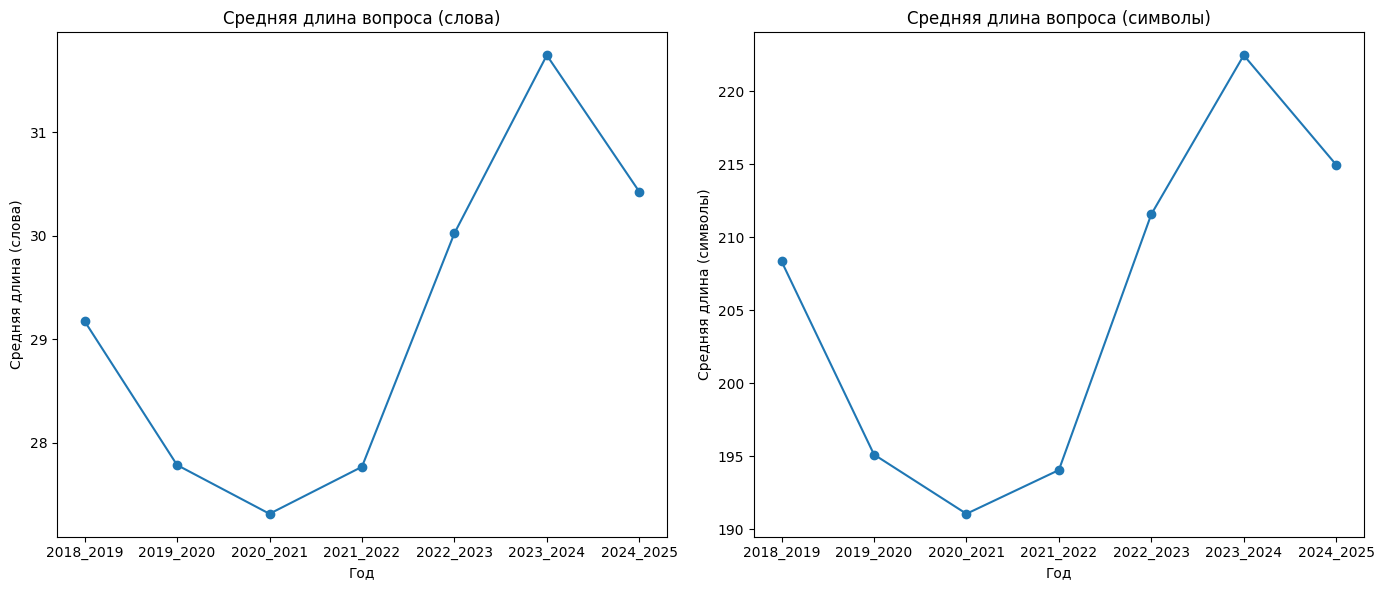

In [40]:
df['Год'] = df['Год'].astype(str)

df_grouped = df.groupby('Год')[['Длина (слова)', 'Длина (символы)']].mean()


fig, axes = plt.subplots(1, 2, figsize=(14, 6))


df_grouped['Длина (слова)'].plot(kind='line', ax=axes[0], marker='o', title="Средняя длина вопроса (слова)")
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Средняя длина (слова)')

df_grouped['Длина (символы)'].plot(kind='line', ax=axes[1], marker='o', title="Средняя длина вопроса (символы)")
axes[1].set_xlabel('Год')
axes[1].set_ylabel('Средняя длина (символы)')

plt.tight_layout()
plt.show()

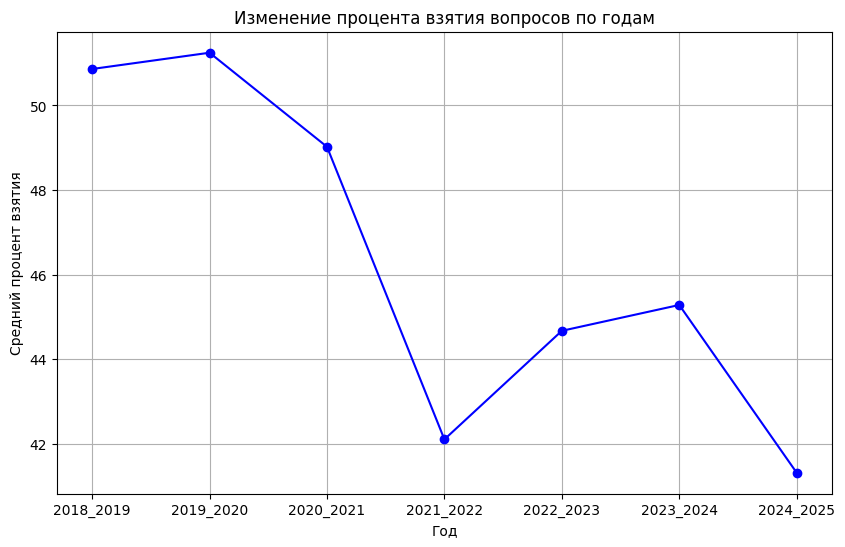

In [41]:
df_grouped = df.groupby('Год')['Процент взятия'].mean()


plt.figure(figsize=(10, 6))
df_grouped.plot(kind='line', marker='o', color='b', title="Изменение процента взятия вопросов по годам")
plt.xlabel('Год')
plt.ylabel('Средний процент взятия')
plt.grid(True)
plt.show()

# 3. Части речи.

In [ ]:
MYSTEM_TO_RU = {
    'S': 'Существительное',
    'V': 'Глагол',
    'A': 'Прилагательное',
    'ADV': 'Наречие',
    'SPRO': 'Местоимение',
    'PR': 'Предлог',
    'CONJ': 'Союз',
    'PART': 'Частица',
    'NUM': 'Числительное',
    'ANUM': 'Числительное-прилагательное',
    'INTJ': 'Междометие'
}

# Эталонное распределение из НКРЯ
REFERENCE_DIST = {
    'Существительное': 28.7,
    'Глагол': 16.9,
    'Прилагательное': 8.5,
    'Наречие': 4.2,
    'Местоимение': 7.9,
    'Предлог': 10.5,
    'Союз': 7.9,
    'Частица': 4.5,
    'Числительное': 1.6,
    'Числительное-прилагательное': 0.3,
    'Междометие': 0.1
}

def analyze_text_mystem(text):
    if not isinstance(text, str) or not text.strip():
        return []
    
    try:
        proc = subprocess.Popen(
            ['mystem', '-lid', '--format', 'json'],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            universal_newlines=True,
            encoding='utf-8'
        )
        stdout, _ = proc.communicate(input=text)
        
        result = []
        for line in stdout.split('\n'):
            line = line.strip()
            if line:
                try:
                    data = json.loads(line)
                    if isinstance(data, dict):
                        result.append(data)
                except json.JSONDecodeError:
                    continue
        return result
    except Exception as e:
        print(f"Ошибка при анализе текста: {e}")
        return []

def get_pos_stats_mystem(texts):
    pos_counter = Counter()
    total_words = 0
    
    for text in texts:
        text = str(text) if not isinstance(text, str) else text
        if not text.strip():
            continue
            
        words_data = analyze_text_mystem(text)
        for word_data in words_data:
            if not isinstance(word_data, dict):
                continue
                
            analysis = word_data.get('analysis')
            if analysis and isinstance(analysis, list) and len(analysis) > 0:
                try:
                    gr = analysis[0].get('gr', '')
                    if gr:
                        pos = gr.split('=')[0].split(',')[0]
                        if pos in MYSTEM_TO_RU:
                            pos_ru = MYSTEM_TO_RU[pos]
                            pos_counter[pos_ru] += 1
                            total_words += 1
                except (AttributeError, IndexError):
                    continue
    
    if total_words == 0:
        return {}
    
    return {pos: (count/total_words)*100 for pos, count in pos_counter.items()}

def prepare_comparison(your_data, name):
    df = pd.DataFrame.from_dict(REFERENCE_DIST, orient='index', columns=['НКРЯ'])
    df[name] = pd.Series(your_data)
    return df.fillna(0).sort_values('НКРЯ', ascending=False)

def analyze_and_compare(df):
    df['Вопрос'] = df['Вопрос'].fillna('').astype(str)
    df['Ответ'] = df['Ответ'].fillna('').astype(str)
    
    questions_dist = get_pos_stats_mystem(df['Вопрос'])
    answers_dist = get_pos_stats_mystem(df['Ответ'])
    
    q_df = prepare_comparison(questions_dist, 'Вопросы')
    a_df = prepare_comparison(answers_dist, 'Ответы')
    
    result_df = pd.DataFrame({
        'Часть речи': q_df.index,
        'НКРЯ (%)': q_df['НКРЯ'],
        'Вопросы (%)': q_df['Вопросы'],
        'Ответы (%)': a_df['Ответы'],
        'Δ вопросов': q_df['Вопросы'] - q_df['НКРЯ'],
        'Δ ответов': a_df['Ответы'] - a_df['НКРЯ']
    }).set_index('Часть речи')
    
    def highlight_diff(val):
        color = 'red' if abs(val) > 5 else ('orange' if abs(val) > 2 else None)
        return f'background-color: {color}' if color else ''
    
    styled_df = result_df.style \
        .applymap(highlight_diff, subset=['Δ вопросов', 'Δ ответов']) \
        .format('{:.1f}%', subset=['НКРЯ (%)', 'Вопросы (%)', 'Ответы (%)']) \
        .format('{:.1f}', subset=['Δ вопросов', 'Δ ответов']) \
        .set_caption('Сравнение распределения частей речи с эталоном НКРЯ')
    
    return styled_df


if __name__ == '__main__':
    styled_result = analyze_and_compare(df)
    display(styled_result)

In [ ]:
result_df = pd.DataFrame({
        'Часть речи': q_df.index,
        'НКРЯ (%)': q_df['НКРЯ'],
        'Вопросы (%)': q_df['Вопросы'],
        'Ответы (%)': a_df['Ответы'],
        'Δ вопросов': q_df['Вопросы'] - q_df['НКРЯ'],
        'Δ ответов': a_df['Ответы'] - a_df['НКРЯ']
    }).set_index('Часть речи')

In [ ]:
styled_df = result_df.style \
        .background_gradient(cmap='coolwarm', subset=['Δ вопросов', 'Δ ответов'], vmin=-10, vmax=10) \
        .format({'НКРЯ (%)': '{:.1f}', 'Вопросы (%)': '{:.1f}', 'Ответы (%)': '{:.1f}',
                'Δ вопросов': '{:.1f}', 'Δ ответов': '{:.1f}'}) \
        .set_caption('Таблица сравнения распределений частей речи')

In [ ]:
display(styled_df)

,НКРЯ (%),Вопросы (%),Ответы (%),Δ вопросов,Δ ответов
Часть речи,,,,,
Существительное,28.7,50.7,71.7,22.0,43.0
Глагол,16.9,26.9,7.5,10.0,-9.4
Предлог,10.5,0.3,0.0,-10.2,-10.5
Прилагательное,8.5,16.1,16.9,7.6,8.4
Местоимение-существительное,7.9,0.1,0.0,-7.8,-7.9
Союз,7.9,0.0,0.0,-7.9,-7.9
Местоимение-прилагательное,4.7,0.8,0.0,-3.9,-4.7
Частица,4.5,0.1,0.2,-4.4,-4.3
Наречие,4.2,2.1,0.5,-2.1,-3.7


# 4. Структурная кластеризация

In [66]:
patterns = {
    "Cоседние буквы алфавита": re.compile(r"соседние буквы алфавита|последовательные буквы алфавита", re.IGNORECASE),
    "Замена ДЕЛАТЬ ЭТО": re.compile(r"ДЕЛАТЬ ЭТО"),
    "Ответ из N слов": re.compile(r"(ответьте|назовите)\s+(?:\w+\W+){0,4}(двумя|тремя|четырьмя|одним)\s+слов(ами|ом)",re.IGNORECASE),
    "Сокращение": re.compile(r"\bмы\b(?:\s+\S+){0,4}?\s+\b(?:сократили)\b", re.IGNORECASE),
    "Пропущенные_буквы": re.compile(r"\b(пропущ(ен[ао]?|ены)|убрали|пропустили)\b(?:\s+\S+){0,4}?\s+\bбукв(а|ы)?\b", re.IGNORECASE),
    "Фамилия_Имя": re.compile(
    r"\b(назовите|напишите|закончите|как(ая|ое|ие)|как)\b(?:\s+\S+){0,4}?\s+\b(фамили(ю|я|ей|и)|им(я|ени|я|и)|звали)\b",
    re.IGNORECASE),
    "Замена ТАМ": re.compile(r"ТАМ"), #okeй
    "Замена ИКС_ИГРЕК": re.compile(r"ИКС|ИГРЕК|АЛЬФ|БЕТ"),
    "Замена ПЕРВЫЙ_ВТОРОЙ": re.compile(r"ПЕРВ|ВТОР"),
    "Замена ТАКОЙ_ТАКАЯ": re.compile(r"ТАК"),
    "Замена ОН_ОНА_ОНИ": re.compile(r"ОН|\b(ИХ)\b|ЕГО|\b(ИМ)\b|Е[ЕЁË]|ЭТО"),
    "Пропуск": re.compile(r"ПРОПУСК|мы пропустили"),
    "Замена слова": re.compile(r"\b(мы|что)\b(?:\s+\S+){0,4}?\s+\b(?:заменили|изменили)\b", re.IGNORECASE)
}

In [71]:
with open("/Users/melondent/Desktop/дс/questions_without_material.json", "r", encoding="utf-8") as f:
    questions = json.load(f)
    
clusters = defaultdict(list)

for q in questions:
    text = q["Вопрос"]
    
    matched = False
    for cluster, pattern in patterns.items():
        if pattern.search(text):
            clusters[cluster].append(q)
            matched = True
            break
    
    if not matched:
        clusters["other"].append(q)

In [72]:
result = []
for q in questions:
    text = q["Вопрос"]
    cluster = "other"
    
    for cluster_name, pattern in patterns.items():
        if pattern.search(text):
            cluster = cluster_name
            break
    
    result.append({
        "id": q["id"],
        "structure_cluster": cluster
    })

with open("id_cluster_mapping.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)

In [73]:
print("\nКоличество вопросов по кластерам:")
for cluster, items in sorted(clusters.items(), key=lambda x: -len(x[1])):
    print(f"- {cluster}: {len(items)}")


Количество вопросов по кластерам:
- Замена ОН_ОНА_ОНИ: 815
- other: 547
- Ответ из N слов: 420
- Замена ИКС_ИГРЕК: 243
- Замена слова: 124
- Пропуск: 94
- Фамилия_Имя: 85
- Замена ДЕЛАТЬ ЭТО: 62
- Замена ТАКОЙ_ТАКАЯ: 59
- Cоседние буквы алфавита: 57
- Замена ПЕРВЫЙ_ВТОРОЙ: 53
- Пропущенные_буквы: 28
- Замена ТАМ: 7
- Сокращение: 6


In [74]:
os.makedirs("structure", exist_ok=True)
for cluster, items in clusters.items():
    filename = f"structure/{cluster}.json"
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(items, f, ensure_ascii=False, indent=2)

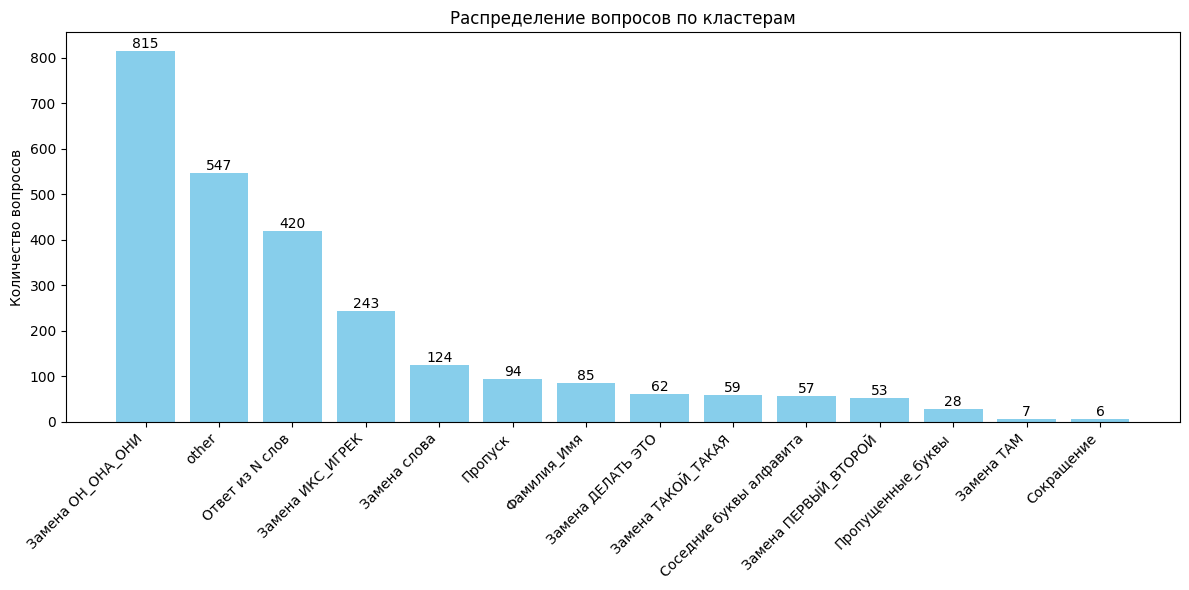

In [75]:
cluster_counts = {name: len(items) for name, items in clusters.items()}
names = list(cluster_counts.keys())
counts = list(cluster_counts.values())

sorted_indices = np.argsort(counts)[::-1]
names = [names[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

plt.figure(figsize=(12, 6))
bars = plt.bar(names, counts, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.ylabel('Количество вопросов')
plt.title('Распределение вопросов по кластерам')
plt.tight_layout()
plt.show()

In [76]:
cluster_df = pd.DataFrame(result)

df = df.merge(cluster_df, on='id', how='left')

In [78]:
df.head()

,id,Пакет,№,Вопрос,Ответ,Зачет,Комментарий,Источник,Авторы,Доля взятия,Процент взятия,Год,Длина (слова),Длина (символы),structure_cluster
0,1,Умлаут Special: Сова в пабе 2019,1.0000,"В передаче Андрея Понкратова рассказывается, ч...",Носами,Нос,Приветствие касанием носа – традиция жителей с...,https://youtu.be/BW63sNTOD8Q?t=1513,"Андрей Кунилов (Мюнхен), Марина Парр (Мюнхен)",120/132,91.0000,2018_2019,28,211,Замена слова
1,2,Умлаут Special: Сова в пабе 2019,2.0000,Одна из сцен “Московского центра драматургии и...,выключать мобильные телефоны,"выключать сотовые телефоны, синонимичные ответы",перед началом спектакля голос по громкоговорит...,https://typical-moscow.ru/mama-cdr-istoriya-od...,"Андрей Кунилов (Мюнхен), Марина Парр (Мюнхен)",107/132,81.0000,2018_2019,23,157,Замена ДЕЛАТЬ ЭТО
2,3,Умлаут Special: Сова в пабе 2019,3.0000,"Статья ""National Geographic"" ""ПРОПУСК тела про...",пластика,точный ответ,"В фотопроекте Григория Шелухина ""Крохотная сме...",http://www.nat-geo.ru/planet/1190948-plastika-...,Борис Рабинович (Тель-Авив),93/132,70.0000,2018_2019,25,212,Пропуск
3,4,Умлаут Special: Сова в пабе 2019,4.0000,"Фантастическое животное демимаска, придуманное...",Нострадамус,Точный ответ,Особо неуязвимым демимаску делает способность ...,https://ru.wikipedia.org/wiki/Нострадамус,Борис Рабинович (Тель-Авив),40/132,30.0000,2018_2019,31,257,Замена ДЕЛАТЬ ЭТО
4,5,Умлаут Special: Сова в пабе 2019,5.0000,В постановке мюнхенского детского театра один ...,[вместо] мозгов,"[вместо] ума. Зачет по слову “мозг”, “ум”, “ра...",Речь о постановке Волшебника страны Оз. В сцен...,NaN,Максим Мозуль (Мюнхен),44/132,33.0000,2018_2019,16,134,other


In [81]:
print("\nСредние показатели по кластерам:")
print(df.groupby("structure_cluster")[["Длина (слова)", "Процент взятия"]].agg(["mean", "std"]))


Средние показатели по кластерам:
                        Длина (слова)         Процент взятия        
                                 mean     std           mean     std
structure_cluster                                                   
Cоседние буквы алфавита       33.2632  7.4607        39.2281 22.2606
other                         27.0238  8.0791        47.3931 25.2468
Замена ДЕЛАТЬ ЭТО             34.1129  8.4020        48.6613 25.1819
Замена ИКС_ИГРЕК              32.6996  7.9182        45.1605 24.0767
Замена ОН_ОНА_ОНИ             27.9730  7.5394        46.3902 24.3490
Замена ПЕРВЫЙ_ВТОРОЙ          31.2830  8.5110        46.1698 23.6609
Замена ТАКОЙ_ТАКАЯ            32.8814  7.1826        40.8644 22.6110
Замена ТАМ                    27.5714  9.3605        54.5714 17.0378
Замена слова                  28.5161  7.6959        42.7984 24.3574
Ответ из N слов               30.1762  8.0388        46.2619 24.2755
Пропуск                       29.4787  7.4382        47.5000 25.6573


In [84]:
corr_table = df.groupby('structure_cluster').apply(
    lambda x: spearmanr(x['Длина (слова)'], x['Процент взятия'])[0]
).round(3)

print("\nТаблица 2. Корреляция Спирмена между длиной вопроса и успешностью по кластерам")
print(corr_table.to_markdown())


Таблица 2. Корреляция Спирмена между длиной вопроса и успешностью по кластерам
| structure_cluster       |      0 |
|:------------------------|-------:|
| Cоседние буквы алфавита | -0.055 |
| other                   |  0.042 |
| Замена ДЕЛАТЬ ЭТО       |  0.008 |
| Замена ИКС_ИГРЕК        | -0.046 |
| Замена ОН_ОНА_ОНИ       |  0.033 |
| Замена ПЕРВЫЙ_ВТОРОЙ    |  0.009 |
| Замена ТАКОЙ_ТАКАЯ      |  0.019 |
| Замена ТАМ              | -0.071 |
| Замена слова            |  0.008 |
| Ответ из N слов         | -0.075 |
| Пропуск                 | -0.109 |
| Пропущенные_буквы       |  0.171 |
| Сокращение              |  0.059 |
| Фамилия_Имя             |  0.217 |


/var/folders/xf/3726vqvn6dq9rsmt7g0rltqr0000gn/T/ipykernel_51453/496165227.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_table = df.groupby('structure_cluster').apply(


In [ ]:
dunn_results = posthoc_dunn(df, val_col='Процент взятия', group_col='structure_cluster')

significant_mask = dunn_results < 0.05

filtered_dunn = dunn_results.where(significant_mask)

print("Статистически значимые попарные различия (тест Данна, p < 0.05):")
print(filtered_dunn)

Статистически значимые попарные различия (тест Данна, p < 0.05):
                         Cоседние буквы алфавита  other  Замена ДЕЛАТЬ ЭТО  \
Cоседние буквы алфавита                      NaN 0.0231             0.0482   
other                                     0.0231    NaN                NaN   
Замена ДЕЛАТЬ ЭТО                         0.0482    NaN                NaN   
Замена ИКС_ИГРЕК                             NaN    NaN                NaN   
Замена ОН_ОНА_ОНИ                         0.0394    NaN                NaN   
Замена ПЕРВЫЙ_ВТОРОЙ                         NaN    NaN                NaN   
Замена ТАКОЙ_ТАКАЯ                           NaN    NaN                NaN   
Замена ТАМ                                   NaN    NaN                NaN   
Замена слова                                 NaN    NaN                NaN   
Ответ из N слов                              NaN    NaN                NaN   
Пропуск                                   0.0500    NaN                NaN   

In [87]:
cluster_stats = df.groupby('structure_cluster').agg({
    'Длина (слова)': ['mean', 'median', 'std', 'min', 'max'],
    'Процент взятия': ['mean', 'median', 'std', 'min', 'max']
}).round(2)

print("Таблица 1. Описательные статистики длины вопросов и процента взятия по кластерам")
print(cluster_stats)

Таблица 1. Описательные статистики длины вопросов и процента взятия по кластерам
                        Длина (слова)                         Процент взятия  \
                                 mean  median     std min max           mean   
structure_cluster                                                              
Cоседние буквы алфавита       33.2600 33.0000  7.4600  20  52        39.2300   
other                         27.0200 27.0000  8.0800   7  55        47.3900   
Замена ДЕЛАТЬ ЭТО             34.1100 32.5000  8.4000  19  56        48.6600   
Замена ИКС_ИГРЕК              32.7000 32.0000  7.9200  14  54        45.1600   
Замена ОН_ОНА_ОНИ             27.9700 28.0000  7.5400  10  65        46.3900   
Замена ПЕРВЫЙ_ВТОРОЙ          31.2800 31.0000  8.5100  16  51        46.1700   
Замена ТАКОЙ_ТАКАЯ            32.8800 34.0000  7.1800  16  49        40.8600   
Замена ТАМ                    27.5700 26.0000  9.3600  14  41        54.5700   
Замена слова                  28.5200 2

In [88]:
corr_table = df.groupby('structure_cluster').apply(
    lambda x: f"ρ = {spearmanr(x['Длина (слова)'], x['Процент взятия'])[0]:.2f} (p = {spearmanr(x['Длина (слова)'], x['Процент взятия'])[1]:.3f})"
)

print("\nТаблица 2. Корреляция Спирмена между длиной вопроса и успешностью по кластерам")
print(corr_table.to_markdown())


Таблица 2. Корреляция Спирмена между длиной вопроса и успешностью по кластерам
| structure_cluster       | 0                     |
|:------------------------|:----------------------|
| Cоседние буквы алфавита | ρ = -0.06 (p = 0.682) |
| other                   | ρ = 0.04 (p = 0.326)  |
| Замена ДЕЛАТЬ ЭТО       | ρ = 0.01 (p = 0.949)  |
| Замена ИКС_ИГРЕК        | ρ = -0.05 (p = 0.477) |
| Замена ОН_ОНА_ОНИ       | ρ = 0.03 (p = 0.351)  |
| Замена ПЕРВЫЙ_ВТОРОЙ    | ρ = 0.01 (p = 0.947)  |
| Замена ТАКОЙ_ТАКАЯ      | ρ = 0.02 (p = 0.887)  |
| Замена ТАМ              | ρ = -0.07 (p = 0.879) |
| Замена слова            | ρ = 0.01 (p = 0.930)  |
| Ответ из N слов         | ρ = -0.08 (p = 0.124) |
| Пропуск                 | ρ = -0.11 (p = 0.296) |
| Пропущенные_буквы       | ρ = 0.17 (p = 0.386)  |
| Сокращение              | ρ = 0.06 (p = 0.912)  |
| Фамилия_Имя             | ρ = 0.22 (p = 0.046)  |


/var/folders/xf/3726vqvn6dq9rsmt7g0rltqr0000gn/T/ipykernel_51453/1846751046.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_table = df.groupby('structure_cluster').apply(


In [89]:
corr_results = df.groupby('structure_cluster').apply(
    lambda x: pd.Series({
        'Корреляция': spearmanr(x['Длина (слова)'], x['Процент взятия'])[0],
        'p-value': spearmanr(x['Длина (слова)'], x['Процент взятия'])[1]
    })
).round(3)


corr_results['Значимость'] = corr_results['p-value'].apply(
    lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
)

print("\nТаблица 2. Корреляция Спирмена между длиной вопроса и успешностью по кластерам")
print(corr_results.to_markdown())


Таблица 2. Корреляция Спирмена между длиной вопроса и успешностью по кластерам
| structure_cluster       |   Корреляция |   p-value | Значимость   |
|:------------------------|-------------:|----------:|:-------------|
| Cоседние буквы алфавита |       -0.055 |     0.682 |              |
| other                   |        0.042 |     0.326 |              |
| Замена ДЕЛАТЬ ЭТО       |        0.008 |     0.949 |              |
| Замена ИКС_ИГРЕК        |       -0.046 |     0.477 |              |
| Замена ОН_ОНА_ОНИ       |        0.033 |     0.351 |              |
| Замена ПЕРВЫЙ_ВТОРОЙ    |        0.009 |     0.947 |              |
| Замена ТАКОЙ_ТАКАЯ      |        0.019 |     0.887 |              |
| Замена ТАМ              |       -0.071 |     0.879 |              |
| Замена слова            |        0.008 |     0.93  |              |
| Ответ из N слов         |       -0.075 |     0.124 |              |
| Пропуск                 |       -0.109 |     0.296 |              |
| Пропущен

/var/folders/xf/3726vqvn6dq9rsmt7g0rltqr0000gn/T/ipykernel_51453/1453852570.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_results = df.groupby('structure_cluster').apply(


In [90]:
groups = [df[df['structure_cluster'] == cluster]['Процент взятия'] for cluster in df['structure_cluster'].unique()]

H_stat, p_value = kruskal(*groups)

print(f"Результаты теста Крускала-Уоллиса:")
print(f"H-статистика = {H_stat:.3f}, p-value = {p_value:.4f}")

Результаты теста Крускала-Уоллиса:
H-статистика = 23.768, p-value = 0.0333
